In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GlueDataset,
    GlueDataTrainingArguments,
    Trainer,
    TrainingArguments,
    default_data_collator,
    glue_compute_metrics,
    glue_output_modes)
from influence_utils.utils_hans import HansDataset

import torch
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from influence_utils.influence import compute_s_test
from influence_utils import glue_utils

In [2]:
tokenizer = AutoTokenizer.from_pretrained("/export/home/Experiments/20200706/")
model = AutoModelForSequenceClassification.from_pretrained("/export/home/Experiments/20200706/")
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased")
model.eval()

train_dataset = GlueDataset(
    args=GlueDataTrainingArguments(
        task_name="mnli",
        max_seq_length=128,
        data_dir="/export/home/Data/Glue/MNLI/"),
    tokenizer=tokenizer)

# eval_dataset = HansDataset(
#     data_dir="/export/home/Data/HANS/",
#     tokenizer=tokenizer,
#     task="hans",
#     max_seq_length=128,
#     overwrite_cache=False,
#     evaluate=True,
# )
eval_dataset = GlueDataset(
    args=GlueDataTrainingArguments(
        task_name="mnli",
        max_seq_length=128,
        data_dir="/export/home/Data/Glue/MNLI/"),
    tokenizer=tokenizer,
    mode="dev")

In [3]:
def custom_forward(
    model,
    input_ids=None,
    attention_mask=None,
    token_type_ids=None,
    position_ids=None,
    head_mask=None,
    inputs_embeds=None,
    labels=None,
    output_attentions=None,
    output_hidden_states=None,
    return_tuple=None,
):
    r"""
    labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
        Labels for computing the sequence classification/regression loss.
        Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
        If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
        If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
    """
    if model.training is True:
        raise ValueError

    outputs = model.bert(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
    )

    pooled_output = outputs[1]

    return model.dropout(pooled_output)


def hans_data_collator(features):
    """
    Data collator that removes the "pairID" key if present.
    """
    batch = default_data_collator(features)
    _ = batch.pop("pairID", None)
    return batch


def get_dataloader(dataset, batch_size, data_collator) -> DataLoader:
    sampler = SequentialSampler(dataset)

    data_loader = DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return data_loader


def run_forward(model, inputs):
    # Implicitly used trainer and model
    has_labels = any(inputs.get(k) is not None for k in ["labels", "lm_labels", "masked_lm_labels"])

    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(trainer.args.device)
    if trainer.args.past_index >= 0:
        inputs["mems"] = past

    with torch.no_grad():
        outputs = model(**inputs)
        if has_labels:
            step_eval_loss, logits = outputs[:2]
            return step_eval_loss, logits
        else:
            logits = outputs[0]
            return logits
        
output_mode = glue_output_modes["mnli"]
def build_compute_metrics_fn(task_name: str):
    def compute_metrics_fn(p):
        if output_mode == "classification":
            preds = np.argmax(p.predictions, axis=1)
        elif output_mode == "regression":
            preds = np.squeeze(p.predictions)
        return glue_compute_metrics(task_name, preds, p.label_ids)

    return compute_metrics_fn


In [4]:
import faiss
index = faiss.index_factory(768, "Flat")

trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
    data_collator=hans_data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=build_compute_metrics_fn("mnli"),
)

train_batch_data_loader = get_dataloader(
    train_dataset,
    batch_size=256,
    data_collator=hans_data_collator)

train_instance_data_loader = get_dataloader(
    train_dataset,
    batch_size=1,
    data_collator=hans_data_collator)

eval_instance_data_loader = get_dataloader(
    eval_dataset,
    batch_size=1,
    data_collator=hans_data_collator)

model.cuda();
model.training

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


False

In [5]:
from tqdm import tqdm
with torch.no_grad():
    for inputs in tqdm(train_batch_data_loader):
        # model.train()
        for k, v in inputs.items():
            inputs[k] = v.cuda()

        outputs = custom_forward(model, **inputs)
        index.add(outputs.cpu().detach().numpy())

100%|██████████| 1534/1534 [13:44<00:00,  1.86it/s]


In [7]:
for i, test_inputs in enumerate(eval_instance_data_loader):
    step_eval_loss, logits = run_forward(model, test_inputs)
    if i > 47 and (test_inputs["labels"] != logits.argmax(dim=1)).item():
        break

In [9]:
i

56

In [10]:
test_features = custom_forward(model, **test_inputs)
test_features = test_features.cpu().detach().numpy()

In [14]:
faiss_index = FAISSIndex(768, "Flat")
# faiss.write_index(index, "/export/home/Experiments/20200713/MNLI.index")
# faiss_index.load("/export/home/Experiments/20200711/MNLI.index")
faiss_index.load("/export/home/Experiments/20200713/MNLI.index")
len(faiss_index)

392702

In [17]:
# influences = torch.load("/export/home/Experiments/20200706/influences.tmp.pt.full")
influences = torch.load("/export/home/Experiments/20200711/influences.tmp.pt")

In [18]:
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


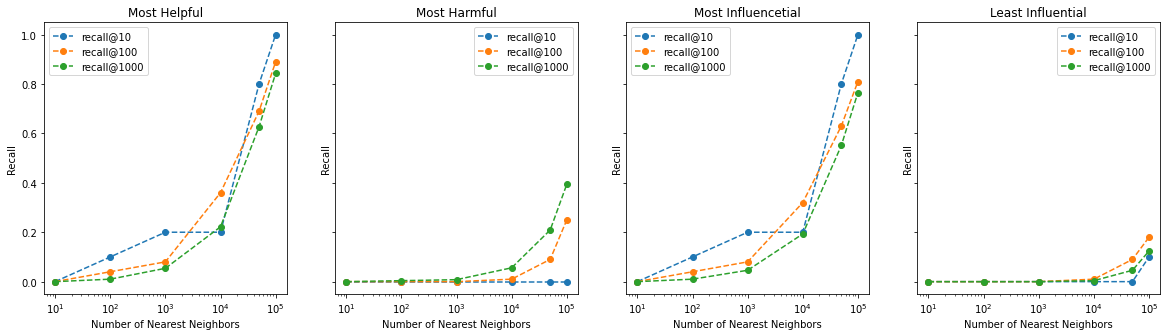

In [20]:
plt.rcParams['figure.figsize'] = [20, 5]
recall_ks = [10, 100, 1000]
ks = [10, 100, 1000, 10000, 50000, 100000]
sorted_indices_small_to_large = np.argsort(influences)
sorted_indices_large_to_small = np.argsort(influences)[::-1]
sorted_indices_abs_large_to_small = np.argsort(np.abs(influences))[::-1]
sorted_indices_abs_small_to_large = np.argsort(np.abs(influences))

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
for i, (name, sorted_indices) in enumerate(zip(
        ["Most Helpful", "Most Harmful",
         "Most Influencetial", "Least Influential"],
        [sorted_indices_small_to_large,
         sorted_indices_large_to_small,
         sorted_indices_abs_large_to_small,
         sorted_indices_abs_small_to_large,
])):
    legends = []
    
    for recall_k in tqdm(recall_ks):
        recalls = []
        influential = sorted_indices[:recall_k]
        influential_set = set(influential.tolist())
        for k in ks:
            distances, indices = faiss_index.search(k=k, queries=test_features)
            indices_set = set(indices.squeeze(axis=0).tolist())
            recall = len(influential_set & indices_set) / len(influential_set)
            recalls.append(recall)

        axes[i].plot(ks, recalls, linestyle='--', marker='o')
        legends.append(f"recall@{recall_k}")

    axes[i].set_title(name)
    axes[i].legend(legends)
    axes[i].set_xscale("log")
    axes[i].set_ylabel("Recall")
    axes[i].set_xlabel("Number of Nearest Neighbors")

In [21]:
# fig.savefig("./20200714-knn-using-CLS.pdf")